### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL/5_Image_Augmentation

### Import libraries

In [ ]:
# Hide warnings
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np

import logging

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import pickle

### Load and process the dataset

In [ ]:
# Load data
data = np.load('../clean_data.npz', allow_pickle=True)

# Save images in a new list (image pixel values are float in [0, 1])
images = data['data']

# Save labels in a new list
labels = data['labels']

# Print data shape
print(images.shape, labels.shape)

(5004, 96, 96, 3) (5004,)


In [ ]:
# Convert labels from string to integer
num_labels = []
for label in labels:
  if label == "healthy":
    num_labels.append(0)
  else:
    num_labels.append(1)

# Convert labels in the one-hot encoding format
num_labels = np.array(num_labels)
labels = tfk.utils.to_categorical(num_labels, 2)

### ConvNeXtLarge

In [ ]:
# Import Feature Extractor with specified settings
feature_extractor = tfk.applications.ConvNeXtLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing=True,
)

785596384/785596384 [==============================] - 24s 0us/step


### Model

In [ ]:
# Define network parameters/callbacks
dropout_rate = 1/10
learning_rate = 1e-3

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    factor=0.999,
    mode='max',
    min_lr=1e-5
)

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True
)

In [ ]:
def build_model(feature_extractor, dropout_rate, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  feature_extractor.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect FeatureExtractor to the input
  x = feature_extractor(inputs)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  dropout = tfkl.Dropout(dropout_rate)(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(dropout)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)
  dropout = tfkl.Dropout(dropout_rate)(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(dropout)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

### KFOLD + FLIP + SHIFT + ROT

In [ ]:
# Define the number of folds for cross-validation
num_folds = 10

# Initialize lists to store training histories, scores, and best epochs
histories = []
scores = []
best_epochs = []

# Create a KFold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True)

# Loop through each fold
for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(images, labels)):

  print("Starting training on fold num: {}".format(fold_idx+1))

  # Build a new dropout model for each fold
  k_model = build_model(feature_extractor, dropout_rate, learning_rate)

  train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip = True,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        rotation_range=90.,
        fill_mode='reflect')


  # Train the model on the training data for this fold
  history = k_model.fit_generator(
      train_datagen.flow((images*255)[train_idx], labels[train_idx], batch_size=16),
      epochs=200,
      steps_per_epoch=len((images)[train_idx])/16,
      validation_data=((images*255)[valid_idx], labels[valid_idx]),
      callbacks = [early_stopping, lr_scheduler]
      ).history


  # Evaluate the model on the validation data for this fold
  score = k_model.evaluate(images[valid_idx], labels[valid_idx], verbose=0)
  scores.append(score[1])

  # Calculate the best epoch for early stopping
  best_epoch = len(history['loss']) - 20
  best_epochs.append(best_epoch)

  # Store the training history for this fold
  histories.append(history)

Starting training on fold num: 1
Epoch 1/200
281/281 [==============================] - 53s 140ms/step - loss: 0.5290 - accuracy: 0.7493 - val_loss: 0.4805 - val_accuracy: 0.7685 - lr: 0.0010
Epoch 2/200
281/281 [==============================] - 35s 124ms/step - loss: 0.3794 - accuracy: 0.8299 - val_loss: 0.3432 - val_accuracy: 0.8463 - lr: 0.0010
Epoch 3/200
281/281 [==============================] - 35s 123ms/step - loss: 0.3455 - accuracy: 0.8492 - val_loss: 0.3940 - val_accuracy: 0.8263 - lr: 0.0010
Epoch 4/200
281/281 [==============================] - 35s 125ms/step - loss: 0.3289 - accuracy: 0.8603 - val_loss: 0.3139 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 5/200
281/281 [==============================] - 35s 123ms/step - loss: 0.3072 - accuracy: 0.8719 - val_loss: 0.3098 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 6/200
281/281 [==============================] - 35s 123ms/step - loss: 0.3000 - accuracy: 0.8728 - val_loss: 0.3130 - val_accuracy: 0.8563 - lr: 0.0010
Epoch 7/200
2

In [ ]:
# Calculate the average best epoch
print (best_epochs)
avg_epochs = int(np.mean(best_epochs))
print(f"Best average epoch: {avg_epochs}")

[26, 38, 43, 66, 66, 27, 49, 19, 50, 25]
Best average epoch: 40


In [ ]:
train_datagen = ImageDataGenerator(
      horizontal_flip=True,
      vertical_flip = True,
      width_shift_range = 0.1,
      height_shift_range = 0.1,
      rotation_range=90.,
      fill_mode='reflect')

# Build the final model using the calculated average best epoch
final_model = build_model(feature_extractor, dropout_rate, learning_rate)

# Train the final model on the combined training and validation data
final_history = final_model.fit_generator(
      train_datagen.flow(images*255, labels, batch_size=16),
      epochs=40,
      steps_per_epoch=len(images)/16,
      validation_data=(images*255, labels),
      callbacks = [lr_scheduler]
      ).history

Epoch 1/40
312/312 [==============================] - 94s 255ms/step - loss: 0.5002 - accuracy: 0.7672 - val_loss: 0.3558 - val_accuracy: 0.8387 - lr: 0.0010
Epoch 2/40
312/312 [==============================] - 68s 216ms/step - loss: 0.3767 - accuracy: 0.8287 - val_loss: 0.3089 - val_accuracy: 0.8633 - lr: 0.0010
Epoch 3/40
312/312 [==============================] - 68s 216ms/step - loss: 0.3433 - accuracy: 0.8503 - val_loss: 0.5065 - val_accuracy: 0.7782 - lr: 0.0010
Epoch 4/40
312/312 [==============================] - 67s 216ms/step - loss: 0.3128 - accuracy: 0.8675 - val_loss: 0.2795 - val_accuracy: 0.8879 - lr: 0.0010
Epoch 5/40
312/312 [==============================] - 67s 215ms/step - loss: 0.2873 - accuracy: 0.8847 - val_loss: 0.2408 - val_accuracy: 0.9011 - lr: 0.0010
Epoch 6/40
312/312 [==============================] - 67s 216ms/step - loss: 0.2830 - accuracy: 0.8739 - val_loss: 0.2450 - val_accuracy: 0.8953 - lr: 0.0010
Epoch 7/40
312/312 [==============================] 

In [ ]:
# Save the model
final_model.save('KFoldAugmentation')
with open('KFoldAugmentation/history.pkl', 'wb') as f:
  pickle.dump(final_history, f)

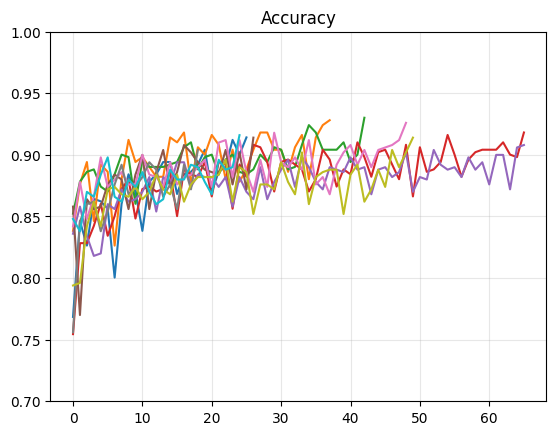

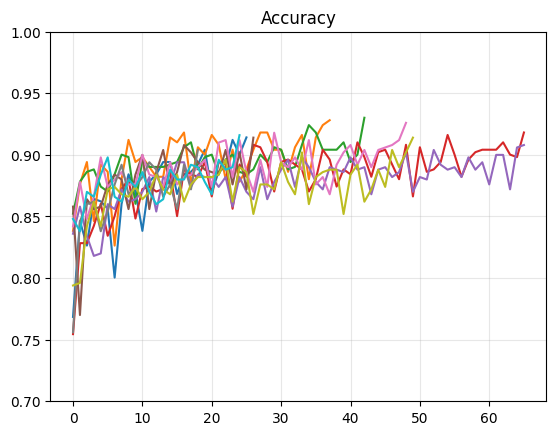

In [ ]:
# Define a list of colors for plotting
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Create a figure for Validation visualization
for fold_idx in range(num_folds):
  plt.plot(histories[fold_idx]['val_accuracy'][:-20], color=colors[fold_idx], label=f'Fold N°{fold_idx+1}')
  plt.ylim(0.7, 1.0)
  plt.title('Accuracy')
  plt.grid(alpha=.3)

# Show the plot
plt.show()